In [54]:
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

# Lennard-Jones Potential
$V_{\text{LJ}}(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] $





In [55]:
# Function to calculate Lennard-Jones potential
def lj_potential(r2, sigma, epsilon):
    r2_inv = (sigma ** 2) / r2
    r6_inv = r2_inv ** 3
    r12_inv = r6_inv ** 2
    return 4 * epsilon * (r12_inv - r6_inv)

In [56]:
# Function to calculate the total potential energy of the system
def total_energy(positions, num_particles, box_length, sigma, epsilon, r_cut):
    energy = 0.0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            rij = positions[i] - positions[j]
            rij = rij - box_length * np.rint(rij / box_length)  # Periodic boundary conditions
            r2 = np.dot(rij, rij)
            if r2 < r_cut ** 2:
                energy += lj_potential(r2, sigma, epsilon)
    return energy

In [57]:
# Read initial positions from XYZ file
def read_xyz(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        num_particles = int(lines[0])
        atom_data = [line.split() for line in lines[2:2 + num_particles]]
        atom_types = [data[0] for data in atom_data]
        positions = np.array([[float(x) for x in data[1:4]] for data in atom_data])
    return atom_types, positions

In [58]:
# Write positions to XYZ file
def write_xyz(file, atom_types, positions, step, energy):
    num_particles = len(atom_types)
    with open(file, 'a') as f:
        f.write(f"{num_particles}\n")
        f.write(f"Step {step}, Energy = {energy}\n")
        for atom_type, pos in zip(atom_types, positions):
            f.write(f"{atom_type} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")


In [77]:
# Lennard-Jones potential parameters for Argon
sigma = 3.4  # in Angstroms
epsilon = 0.238  # in kcal/mol

# Simulation parameters
temperature = 100.0  # Temperature in Kelvin
r_cut = 2.5 * sigma  # Cutoff distance, scaled by sigma
num_steps = 1000  # Number of Monte Carlo steps
dr_max = 0.1 * sigma  # Maximum displacement, scaled by sigma
box_length = 10.0  # Box dimension in Angstroms

In [78]:
input_file = 'argons.xyz'
output_file = 'trajectory_out.xyz'
atom_types, positions = read_xyz(input_file)
num_particles = len(atom_types)


# Metropolis Criterion
$
\text{Accept if } r < \exp\left( -\frac{\Delta E}{k_B T} \right)
$


In [79]:
#Monte Carlo loop
for step in range(1, num_steps + 1):
    i = np.random.randint(num_particles)
    old_position = positions[i].copy()
    old_energy = total_energy(positions, num_particles, box_length, sigma, epsilon, r_cut)

    # Trial move
    positions[i] += dr_max * (np.random.rand(3) - 0.5)
    positions[i] = positions[i] - box_length * np.rint(positions[i] / box_length)  # PBC

    new_energy = total_energy(positions, num_particles, box_length, sigma, epsilon, r_cut)
    delta_energy = new_energy - old_energy

    # Metropolis criterion
    if np.random.rand() < np.exp(-delta_energy / (1.38064852e-23 * temperature / 1.9872041e-3)):
        energy = new_energy
    else:
        positions[i] = old_position  # Reject move

    # Write positions to the output file after each step
    if step%10==0:
        write_xyz(output_file, atom_types, positions, step, energy)

In [ ]:
#!conda install mdtraj nglview

In [86]:
import mdtraj as md
import nglview as nv

# Define the atom types as needed
num_atoms = 35  # Replace with the actual number of atoms in your XYZ file
atom_types = ['Ar'] * num_atoms  # Adjust this line if your atoms are different

# Create a simple topology for the XYZ file
top = md.Topology()
chain = top.add_chain()
residue = top.add_residue("RES", chain)
for atom_type in atom_types:
    top.add_atom(atom_type, md.element.Element.getBySymbol(atom_type), residue)

# Load the XYZ file with the created topology
traj = md.load_xyz('trajectory_out.xyz', top=top)
# Visualize the trajectory using nglview
view = nv.show_mdtraj(traj)
view.clear_representations()
view.add_spacefill(radiusType='radius', radius=0.5)
view


NGLWidget(max_frame=99)

# Average Potential Energy

In [87]:
# Function to read XYZ file with multiple frames
def read_xyz_multi_frame(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    frames = []
    i = 0
    while i < len(lines):
        num_particles = int(lines[i].strip())
        positions = []
        for line in lines[i+2:i+2+num_particles]:
            _, x, y, z = line.split()
            positions.append([float(x), float(y), float(z)])
        positions = np.array(positions)
        frames.append(positions)
        i += num_particles + 2
    
    return frames, num_particles

In [88]:
frames, num_particles = read_xyz_multi_frame(output_file)
# Calculate the total potential energy for each frame
energies = []
for positions in frames:
    total_potential_energy = total_energy(positions, num_particles, box_length, sigma, epsilon, r_cut)
    energies.append(total_potential_energy)

# Calculate the average potential energy per frame
average_potential_energy_per_frame = np.mean(energies)

print(f"Average potential energy per frame: {average_potential_energy_per_frame:.4f}")

Average potential energy per frame: 2436.0715


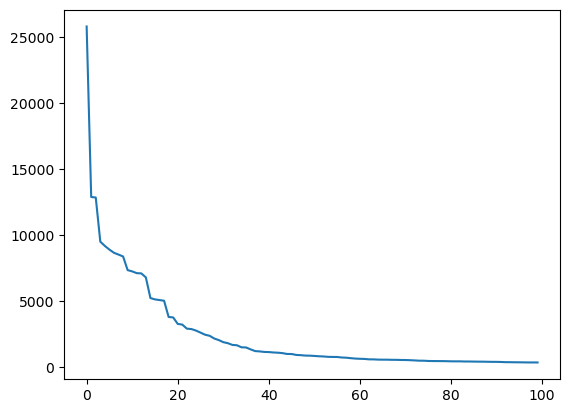

In [89]:
import matplotlib.pyplot as plt
plt.plot(energies)

In [90]:
# Function to compute the distance between two points considering periodic boundary conditions
def minimum_image_distance(r1, r2, box_length):
    rij = r1 - r2
    rij = rij - box_length * np.rint(rij / box_length)
    return np.sqrt(np.dot(rij, rij))

# Function to compute the closest distances for each particle
def closest_distances(positions, num_particles, box_length):
    closest_dist = []
    for i in range(num_particles):
        min_dist = np.inf
        for j in range(num_particles):
            if i != j:
                dist = minimum_image_distance(positions[i], positions[j], box_length)
                if dist < min_dist:
                    min_dist = dist
        closest_dist.append(min_dist)
    return closest_dist

/var/folders/ld/nqh1nljd523g0lykfn_327t40000gn/T/ipykernel_47742/3125207288.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_closest_distances)


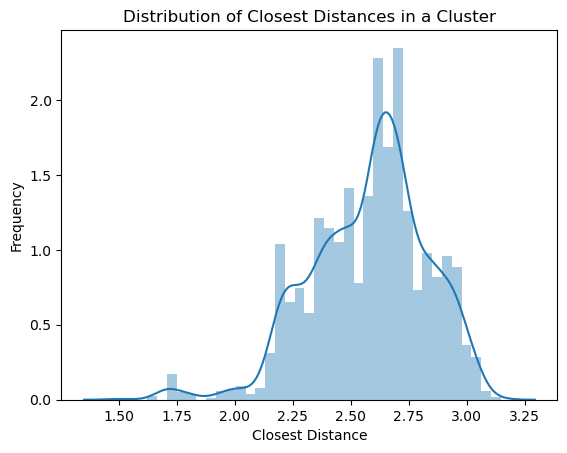

In [92]:
# Calculate the closest distances for all frames
all_closest_distances = []
for positions in frames:
    closest_dist = closest_distances(positions, num_particles, box_length)
    all_closest_distances.extend(closest_dist)

# Plot the distribution of the closest distances
import seaborn as sns
sns.distplot(all_closest_distances)
plt.xlabel('Closest Distance')
plt.ylabel('Density')
plt.title('Distribution of Closest Distances in a Cluster')
plt.show()